## TP 4 : Méthode des éléments finis

In [6]:
import numpy as np
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import matplotlib.pyplot as plt

## Partie 1. (Elements finis P1)

### 1 2

In [7]:
class mesh:
    def __init__(self, Nel, xmin=0.0, xmax=1.0):
        self.Nel = Nel
        self.Ndof = Nel + 1
        self.xmin = 0.0
        self.xmax = 1.0
        self.nodes = np.empty(Nel + 1)
        self.h = np.empty(Nel)

    def init_uniform(self):
        self.nodes = np.linspace(self.xmin, self.xmax, self.Ndof)
        self.h = np.diff(self.nodes)

    def init_random(self):
        self.nodes = self.xmin + (self.xmax - self.xmin) * np.random.rand(self.Ndof)
        self.nodes[0] = self.xmin
        self.nodes[1] = self.xmax
        self.nodes.sort()
        self.h = np.diff(self.nodes)

    def test(self):
        self.init_uniform()
        print("Nodes:", self.nodes)
        print("Element sizes:", self.h)
        self.init_random()
        print("Nodes:", self.nodes)
        print("Element sizes:", self.h)

mh = mesh(4, 0, 1)
mh.test()

Nodes: [0.   0.25 0.5  0.75 1.  ]
Element sizes: [0.25 0.25 0.25 0.25]
Nodes: [0.         0.21438228 0.52501333 0.6941194  1.        ]
Element sizes: [0.21438228 0.31063105 0.16910606 0.3058806 ]


### 3 4 5 7

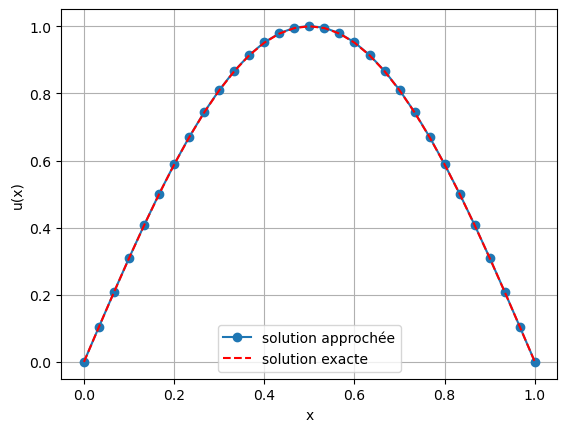

In [8]:
class fem:
    def __init__(self, mesh):
        self.mesh = mesh

    def matrixA_P1(self):
        h = self.mesh.h

        diagK = (1/h[:-1] + 1/h[1:])
        offdiagK = -1/h[1:-1]

        diagM = (h[:-1] + h[1:]) / 3.0
        offdiagM = h[1:-1] / 6.0

        diagA = diagK + diagM
        offdiagA = offdiagK + offdiagM

        A = spsp.diags([offdiagA, diagA, offdiagA], offsets=[-1,0,1], format='csr')

        return A

    def rhs_P1(self,f):
        nodes = self.mesh.nodes
        h = self.mesh.h
        Ndof = self.mesh.Ndof
        b = np.zeros(Ndof)

        for i in range(self.mesh.Nel):
            x_left = nodes[i]
            x_right = nodes[i+1]

            b[i] += h[i] * f(x_left) / 2.0
            b[i+1] += h[i] * f(x_right) / 2.0

        return b[1:-1]
    
    def solve(self, f, plot=True):
        A = self.matrixA_P1()
        b = self.rhs_P1(f)

        uu = spsplin.spsolve(A, b)

        Ndof = self.mesh.Ndof
        u = np.zeros(Ndof)
        u[1:-1] = uu

        if plot:
            x = self.mesh.nodes

            test_val = f(0.5)
            u_exact = np.sin(np.pi*x)

            plt.figure()
            plt.plot(x, u, 'o-', label='solution approchée')
            plt.plot(x, u_exact, 'r--', label='solution exacte')
            plt.xlabel('x')
            plt.ylabel('u(x)')
            plt.legend()
            plt.grid(True)
            plt.show()

        return u

mh = mesh(30, 0, 1)
mh.init_uniform()
fe = fem(mh)

A = fe.matrixA_P1()

# print(A.toarray())

def f_test(x):
    return (np.pi**2+1)*np.sin(np.pi*x)

u_approx = fe.solve(f_test, plot=True)

### 6

Let $u(x) = \sin(\pi x)$ in $-u''(x) + u(x) = f(x)$：

$u(x) = \sin(\pi x) \quad \Rightarrow \quad u'(x) = \pi \cos(\pi x) \quad \Rightarrow \quad u''(x) = -\pi^2 \sin(\pi x)$

$-(-\pi^2 \sin(\pi x)) + \sin(\pi x) = f(x)$

$f(x) = (\pi^2 + 1) \sin(\pi x)$

## Partie 2. (Etude)

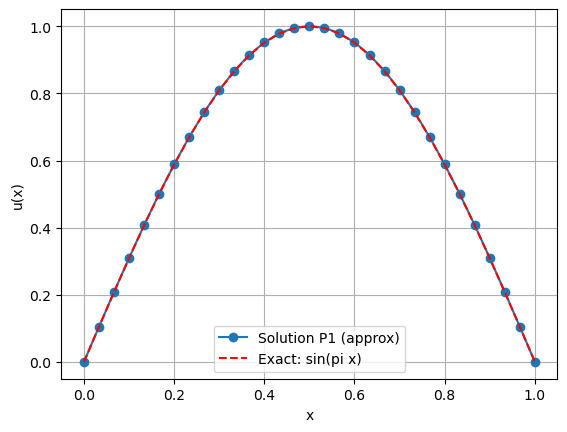

L2 error with Nel=30: 0.0004987767025623769


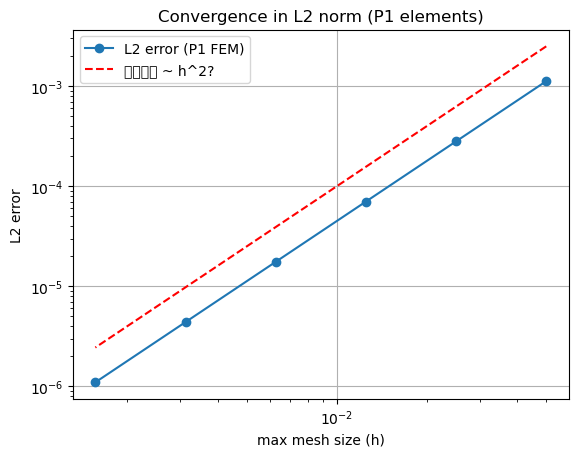

Nel=20 -> Nel=40:  误差阶约 = 2.00
Nel=40 -> Nel=80:  误差阶约 = 2.00
Nel=80 -> Nel=160:  误差阶约 = 2.00
Nel=160 -> Nel=320:  误差阶约 = 2.00
Nel=320 -> Nel=640:  误差阶约 = 2.00
===== 条件数测试 =====
Nel = 20:
  - 均匀网格的 cond(A)  = 1.47e+02
  - 随机网格的 cond(A)  = 1.33e+03
Nel = 40:
  - 均匀网格的 cond(A)  = 5.88e+02
  - 随机网格的 cond(A)  = 2.15e+04
Nel = 80:
  - 均匀网格的 cond(A)  = 2.35e+03
  - 随机网格的 cond(A)  = 7.22e+04
Nel = 160:
  - 均匀网格的 cond(A)  = 9.42e+03
  - 随机网格的 cond(A)  = 2.00e+06
===== 完毕 =====


In [9]:
class mesh:
    def __init__(self, Nel, xmin=0.0, xmax=1.0):
        self.Nel = Nel
        self.Ndof = Nel + 1
        self.xmin = xmin
        self.xmax = xmax
        self.nodes = np.empty(self.Ndof)
        self.h = np.empty(self.Nel)

    def init_uniform(self):
        self.nodes = np.linspace(self.xmin, self.xmax, self.Ndof)
        self.h = np.diff(self.nodes)

    def init_random(self):
        self.nodes = self.xmin + (self.xmax - self.xmin) * np.random.rand(self.Ndof)
        self.nodes[0] = self.xmin
        self.nodes[-1] = self.xmax
        self.nodes.sort()
        self.h = np.diff(self.nodes)

    def norm_P1(self, u):
        """
        计算向量 u 对应的有限元函数的 L^2 范数和 H^1 半范数（离散意义下）。
        
        注意：
        - u[i] 表示节点 x_i 上的函数值
        - 对每个单元 [x_i, x_{i+1}]，其长度为 h[i]
        - 对一次元 (P1)，在单元内 u(x) 是线性插值。 
        
        计算方式示例：
          L^2 范数 (离散近似)：
              \|u\|_{L^2}^2 ≈ Σ_{i=0..Nel-1} ∫_{x_i}^{x_{i+1}} (u_i + (u_{i+1}-u_i)*... )^2 dx
            这里可以使用梯形法或者准确公式。
            为简便，这里我们直接用分段梯形法 (也可做更精确的单元内解析):
            
              ∫_{x_i}^{x_{i+1}} (u(x))^2 dx ≈ (h[i]/6) * [ (u_i)^2 + (u_{i+1})^2 + (u_i * u_{i+1]) ]
            
          H^1 半范数 (离散):
              \|u\|_{H^1} 的半范数 ~ ( Σ_{i=0..Nel-1} ∫_{x_i}^{x_{i+1}} (u'(x))^2 dx )^(1/2)
            由于单元内是一次多项式:
              u'(x) = (u_{i+1} - u_i) / h[i]
            所以
              ∫_{x_i}^{x_{i+1}} (u'(x))^2 dx = (u_{i+1} - u_i)^2 / h[i]

        返回: (L2_norm, H1_seminorm)
        """
        L2_sq = 0.0
        H1_semi_sq = 0.0
        for i in range(self.Nel):
            hi = self.h[i]
            ui = u[i]
            ui1 = u[i+1]

            # （1）L^2 部分的分片梯形/Simpson等简化做法 (这里用一个简单近似公式)
            # 形如 ∫(u_i + (u_{i+1}-u_i)*(x - x_i)/h[i])^2 dx
            # 这里给个简单近似：三点值的加权
            # 也可使用更准确的公式，或者用三点 Simpson
            L2_sq += (hi / 6.0) * (ui**2 + ui1**2 + ui*ui1)

            # （2）H^1 半范数
            diff = ui1 - ui
            H1_semi_sq += diff*diff / hi

        L2_norm = np.sqrt(L2_sq)
        H1_seminorm = np.sqrt(H1_semi_sq)
        return (L2_norm, H1_seminorm)


# ========== 2. 定义 fem 类（与第一部分类似，增加误差返回） ==========

class fem:
    def __init__(self, mesh):
        self.mesh = mesh

    def matrixA_P1(self):
        """
        构造一次元 (P1) 的刚度矩阵 + 质量矩阵：
           A = (K + M)
        其中 K 来自 -u''，M 来自 +u
        """
        h = self.mesh.h
        Nel = self.mesh.Nel
        Ndof = self.mesh.Ndof

        # 对角与非对角分量 (注意边界剔除后在组装中也要处理)
        # K部分:  1/h[i-1] + 1/h[i]   on diag,  -1/h[i] on offdiag
        # M部分: (h[i-1] + h[i])/3   on diag,   h[i]/6  on offdiag
        #
        # 需要仔细对齐索引。此处简化处理，构造 (Ndof-2)x(Ndof-2) 的内部点矩阵。
        # 这里给出的公式适用于均匀网格相邻相加，但要小心边界索引。
        
        # Pythonic 写法示例（更通用做法需要拼装更小的区间，或仔细分块）

        # diagK[i] 表示 A_ii 里由K部分贡献
        diagK = np.zeros(Ndof-2)
        for i in range(1, Ndof-1):
            diagK[i-1] = 1.0/h[i-1] + 1.0/h[i]

        offK = np.zeros(Ndof-3)
        for i in range(1, Ndof-2):
            offK[i-1] = -1.0/h[i]

        # diagM[i]: M在对角上的贡献
        diagM = np.zeros(Ndof-2)
        for i in range(1, Ndof-1):
            diagM[i-1] = (h[i-1] + h[i]) / 3.0

        offM = np.zeros(Ndof-3)
        for i in range(1, Ndof-2):
            offM[i-1] = h[i] / 6.0

        # A = diag + off
        diagA = diagK + diagM
        offA = offK + offM

        # 用对角线存储生成稀疏矩阵
        A = spsp.diags([offA, diagA, offA], offsets=[-1,0,1], format='csr')
        return A

    def rhs_P1(self, f):
        """
        组装右端项 b，使用分段梯形来计算 ∫ f * phi_i
        注意需要剔除边界点 (0,1) 的未知数，对应 Ndof-2 的自由度。
        """
        nodes = self.mesh.nodes
        h = self.mesh.h
        Ndof = self.mesh.Ndof

        b_full = np.zeros(Ndof)
        for i in range(self.mesh.Nel):
            x_left = nodes[i]
            x_right = nodes[i+1]
            # 分段梯形近似
            b_full[i]   += 0.5 * h[i] * f(x_left)
            b_full[i+1] += 0.5 * h[i] * f(x_right)

        # 仅返回内部点 [1:-1] 的分量
        return b_full[1:-1]

    def solve(self, f, plot=True, return_error=True):
        """
        求解 A*u = b 并可选地绘制数值解和精确解，
        同时返回与精确解 sin(pi*x) 的 L^2 误差。
        """
        # 1) 组装矩阵和右端项
        A = self.matrixA_P1()
        b = self.rhs_P1(f)
        
        # 2) 求解
        u_inner = spsplin.spsolve(A, b)  # 大小为 Ndof-2
        Ndof = self.mesh.Ndof
        # 将边界补上 (u(0)=0, u(1)=0)
        u = np.zeros(Ndof)
        u[1:-1] = u_inner

        # 3) 如果要画图，假设真解为 sin(pi * x)，仅作为测试(可根据实际情况改)
        x = self.mesh.nodes
        u_exact = np.sin(np.pi*x)

        if plot:
            plt.figure()
            plt.plot(x, u, 'o-', label='Solution P1 (approx)')
            plt.plot(x, u_exact, 'r--', label='Exact: sin(pi x)')
            plt.xlabel('x')
            plt.ylabel('u(x)')
            plt.legend()
            plt.grid(True)
            plt.show()

        # 4) 返回 L2 误差 (可做更多分析)
        if return_error:
            # 计算误差向量 e = (u - u_exact)
            e = u - u_exact
            # 用 mesh.norm_P1 来算其 L2 范数
            L2_e, _ = self.mesh.norm_P1(e)
            return u, L2_e
        else:
            return u


# ========== 3. 测试与数值实验 ==========

def f_test(x):
    """
    对应题目中要求满足: -u'' + u = f
    若 u(x)=sin(pi x)，则 u''(x) = -pi^2 sin(pi x)
    => -u''(x) + u(x) = (pi^2 + 1)*sin(pi x)
    """
    return (np.pi**2 + 1)*np.sin(np.pi*x)


def test_convergence():
    """
    测试不同 Nel 下的收敛性，并绘制误差随 h 的变化（对数坐标）。
    """
    Nel_list = [20, 40, 80, 160, 320, 640]
    h_list = []
    err_list = []

    for Nel in Nel_list:
        # 1) 建立网格
        mh = mesh(Nel, 0, 1)
        mh.init_uniform()  # 均匀网格
        h_list.append(np.max(mh.h))

        # 2) 构造并求解
        fe = fem(mh)
        _, L2_error = fe.solve(f_test, plot=False, return_error=True)
        err_list.append(L2_error)
    
    # 绘制 log-log
    plt.figure()
    plt.loglog(h_list, err_list, 'o-', label='L2 error (P1 FEM)')
    plt.loglog(h_list, [h**2 for h in h_list], 'r--', label='参考斜率 ~ h^2?')  # 理论上一阶(P1)常见是 ~h^1 在 H^1 中；L^2 中可达 ~h^2
    plt.xlabel('max mesh size (h)')
    plt.ylabel('L2 error')
    plt.title('Convergence in L2 norm (P1 elements)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 计算并打印数值阶： slope = log(err[i]/err[i+1]) / log(h[i]/h[i+1])
    for i in range(len(Nel_list)-1):
        order = np.log(err_list[i]/err_list[i+1]) / np.log(h_list[i]/h_list[i+1])
        print(f"Nel={Nel_list[i]} -> Nel={Nel_list[i+1]}:  误差阶约 = {order:.2f}")


def test_condition_number():
    """
    对比均匀网格与随机网格下的刚度矩阵 (A) 的条件数
    """
    Nel_list = [20, 40, 80, 160]  # 仅示例

    print("===== 条件数测试 =====")
    for Nel in Nel_list:
        # 均匀网格
        mh_uni = mesh(Nel, 0, 1)
        mh_uni.init_uniform()
        fe_uni = fem(mh_uni)
        A_uni = fe_uni.matrixA_P1().toarray()
        cond_uni = np.linalg.cond(A_uni)

        # 随机网格
        mh_rand = mesh(Nel, 0, 1)
        mh_rand.init_random()
        fe_rand = fem(mh_rand)
        A_rand = fe_rand.matrixA_P1().toarray()
        cond_rand = np.linalg.cond(A_rand)

        print(f"Nel = {Nel}:")
        print(f"  - 均匀网格的 cond(A)  = {cond_uni:.2e}")
        print(f"  - 随机网格的 cond(A)  = {cond_rand:.2e}")
    print("===== 完毕 =====")


# ========== 4. 运行示例 ==========

if __name__ == "__main__":
    # 单个网格测试
    mh = mesh(30, 0, 1)
    mh.init_uniform()
    fe = fem(mh)

    # 求解并画图
    u_approx, L2_err = fe.solve(f_test, plot=True, return_error=True)
    print("L2 error with Nel=30:", L2_err)

    # 测试收敛性
    test_convergence()

    # 测试条件数
    test_condition_number()


## Partie 3 (Eléments finis P_2).

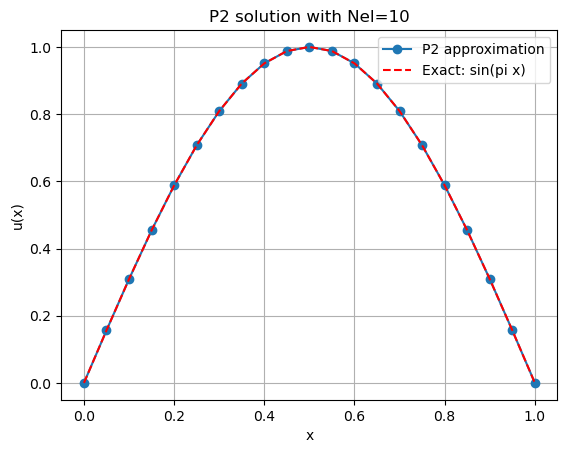

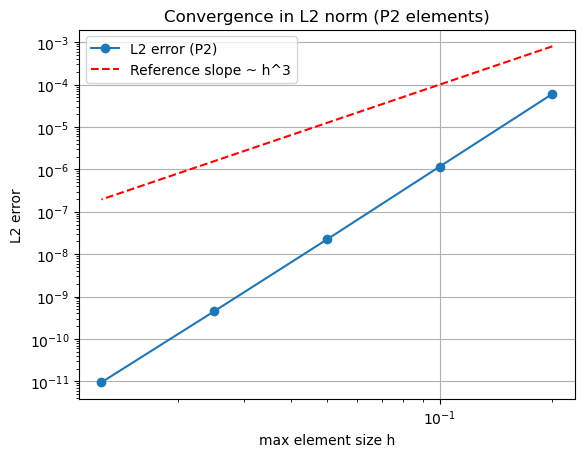

Nel=5 -> 10,   误差阶 ~ 5.69
Nel=10 -> 20,   误差阶 ~ 5.71
Nel=20 -> 40,   误差阶 ~ 5.63
Nel=40 -> 80,   误差阶 ~ 5.57


In [10]:
# ---------------------------------
# 第 1 步：定义 mesh 类 (兼容 P2)
# ---------------------------------
class mesh:
    def __init__(self, Nel, xmin=0.0, xmax=1.0, deg=2):
        """
        Nel  : 单元数
        deg  : 每个单元的多项式阶数 (这里演示 P2，即 deg=2)
        dof  : 存储网格所有自由度的坐标
        """
        self.Nel = Nel
        self.xmin = xmin
        self.xmax = xmax
        self.deg = deg  # 默认为2

        # 根据 deg，计算全局自由度个数: deg*Nel + 1
        self.Ndof = self.deg * self.Nel + 1

        # 对于纯“分区节点”（即每个单元末端），我们存一下:
        #   注意：这和 "dof" 不同。dof 里是包含单元内部节点在内的所有自由度坐标
        self.nodes_base = np.empty(self.Nel+1)  # 存 Nel+1 个分区节点
        self.h = np.empty(self.Nel)            # 每个单元大小

        # 最后，要构造 self.dof（大小 Ndof），包含所有自由度坐标
        self.dof = np.empty(self.Ndof)

    def init_uniform(self):
        """
        建立均匀网格 (P2)：
        1) 先在 [xmin, xmax] 上做 Nel 个均匀单元。
        2) 每个单元再细分 deg = 2 段；这样每个单元就有 (deg+1) 个局部点（含两端），
           全局上共 deg*Nel + 1 个自由度。
        """
        # 1) 先设置单元分区端点 (Nel+1 个)
        self.nodes_base = np.linspace(self.xmin, self.xmax, self.Nel+1)
        self.h = np.diff(self.nodes_base)

        # 2) 对每个单元 [ x_j, x_{j+1} ]，均匀放置 (deg+1) 点，构造 self.dof
        idx_global = 0
        for el in range(self.Nel):
            xL = self.nodes_base[el]
            xR = self.nodes_base[el+1]
            h_el = xR - xL

            # 局部点: x_{j,k} = xL + (k/deg)*h_el, k=0..deg
            for k in range(self.deg+1):
                # 只有第一个单元 或每个单元的第一个节点需要放进去
                # 否则会重复。一个简便做法是，除最后一个节点外都放，最后一个单元的最后一个节点再加
                # 但也可直接放，然后在索引上做判断。
                # 这里示例：若不是最后一个单元或者不是局部最后一个 k，则直接写入
                self.dof[idx_global] = xL + (k/self.deg)*h_el
                idx_global += 1

            # 注意：上面会多数一次节点(因为每个单元的最后一个局部节点和下一个单元的第一个局部节点是同一个坐标)
            # 处理方法：把 idx_global 回退 1
            if el < self.Nel-1:
                idx_global -= 1

    def init_random(self):
        """
        随机网格 (P2):
        1) 随机生成单元分区 (Nel+1个端点)，并保证有序
        2) 对每个单元放置 (deg+1) 个局部点
        """
        # 1) 端点
        random_pts = np.random.rand(self.Nel-1)
        random_pts.sort()
        self.nodes_base[0] = self.xmin
        self.nodes_base[-1] = self.xmax
        for i in range(1, self.Nel):
            self.nodes_base[i] = self.xmin + (self.xmax - self.xmin)*random_pts[i-1]

        self.nodes_base.sort()
        self.h = np.diff(self.nodes_base)

        # 2) 构造 self.dof
        idx_global = 0
        for el in range(self.Nel):
            xL = self.nodes_base[el]
            xR = self.nodes_base[el+1]
            h_el = xR - xL
            for k in range(self.deg+1):
                self.dof[idx_global] = xL + (k/self.deg)*h_el
                idx_global += 1
            if el < self.Nel-1:
                idx_global -= 1

    def connect(self, el, k):
        """
        给定单元号 el, 局部自由度 k (0..deg)，返回全局自由度编号 index
        el 范围: 0..(Nel-1)
        k  范围: 0..deg
        """
        # 一个单元含 (deg+1) 个局部点，每个单元首个局部点对应全局 index = el*deg
        # 因此 global_index = el*deg + k
        return el*self.deg + k

# ---------------------------------
# 第 2 步：定义 fem 类 (P2) 
#         - 组装矩阵 A
#         - 组装右端项 b
#         - 计算范数
#         - 求解并绘图
# ---------------------------------
class femP2:
    def __init__(self, mesh):
        self.mesh = mesh
        # 参考单元 [0,1] 上的质量矩阵 M 与刚度矩阵 K
        # 题目给出:
        # M = np.array([[2,1,-0.5],
        #               [1,8,   1],
        #               [-0.5,1,2]]) / 15
        # K = np.array([[7, -8, 1],
        #               [-8,16,-8],
        #               [1, -8, 7]]) / 3
        self.M_ref = np.array([[ 2.0,  1.0, -0.5],
                               [ 1.0,  8.0,  1.0],
                               [-0.5, 1.0,  2.0]]) / 15.0

        self.K_ref = np.array([[ 7.0, -8.0,  1.0],
                               [-8.0,16.0, -8.0],
                               [ 1.0, -8.0,  7.0]]) / 3.0

    def matrixA(self):
        """
        组装全局矩阵 A = (K + M).
        
        对于每个单元 el:
          A_{i,j} += (1/h_el) * K_ref[ni, nj] + h_el * M_ref[ni,nj]
        其中:
          i = connect(el, ni)
          j = connect(el, nj)
          h_el = x_{el+1} - x_{el}
        因为 -u'' + u = 0 对应的刚度K + 质量M （缩放方式见题目公式）
        """
        Nel = self.mesh.Nel
        Ndof = self.mesh.Ndof
        dof = self.mesh.dof
        # 对每个单元的区间长度
        # 也可用 self.mesh.h，但要注意 p2 时 self.mesh.h 只存分区端点 [nodes_base] 的差
        # 不过这里是一致的，因为在1D下，每个单元的 length = self.mesh.h[el].
        h_all = self.mesh.h

        # 准备一个稀疏矩阵 (Ndof x Ndof)，使用 dok 格式方便组装
        A_dok = spsp.dok_matrix((Ndof, Ndof), dtype=float)

        for el in range(Nel):
            h_el = h_all[el]
            inv_h = 1.0 / h_el

            # 遍历局部基函数 ni, nj
            for ni in range(self.mesh.deg+1):
                i = self.mesh.connect(el, ni)
                for nj in range(self.mesh.deg+1):
                    j = self.mesh.connect(el, nj)

                    # 别忘了：边界上的自由度( i,j=0 或 Ndof-1 )是已知 0(Dirichlet)； 
                    # 这里仍然先组装到矩阵中，后续在求解时会相应处理。
                    # (在 1D Dirichlet 情形可直接把首末点去掉，也可先装满然后给方程做处理)

                    # 刚度 K 部分： (1/h_el) * K_ref[ni, nj]
                    valK = inv_h * self.K_ref[ni, nj]
                    # 质量 M 部分： h_el * M_ref[ni, nj]
                    valM = h_el * self.M_ref[ni, nj]

                    A_dok[i, j] += (valK + valM)

        # 转成 csr
        A = A_dok.tocsr()
        return A

    def rhs(self, f):
        """
        计算右端项 b，b_i = ∫( f(x)*phi_i(x) ), 
        使用辛普森法(或其他数值方法)对每个单元做分段加和。
        
        对于单元 el 的参考坐标 y in [0,1]:
          x(y) = xL + y*h_el
          phi_i(x(y)) = phi_ref( y )  (对应局部基函数之一)
          f(x(y)) 用若干点求值做 Simpson
        """
        Nel = self.mesh.Nel
        Ndof = self.mesh.Ndof
        b = np.zeros(Ndof)
        dof = self.mesh.dof

        # 在参考单元 [0,1] 上用三点： 0, 1/2, 1 做 Simpson
        # 三点的权重 (1/6, 4/6, 1/6)；也可自定义
        # 对应 y0=0, y1=0.5, y2=1
        w_simp = np.array([1.0/6.0, 4.0/6.0, 1.0/6.0])
        y_simp = np.array([0.0, 0.5, 1.0])

        # 参考基函数 phi_bar0, phi_bar1, phi_bar2 在 y_simp 上的取值
        # phi_bar0(y) = (2y-1)(y-1)  ; phi_bar1(y) = 4y(1-y)  ; phi_bar2(y)= y(2y-1)
        def phi_bar0(y):
            return (2.0*y - 1.0)*(y - 1.0)
        def phi_bar1(y):
            return 4.0*y*(1.0 - y)
        def phi_bar2(y):
            return y*(2.0*y - 1.0)

        # 预先算出 3 个基函数在 y_simp 上的值，方便后面循环
        phi_vals = np.zeros((3, self.mesh.deg+1))
        # deg+1=3 个基函数，对应 0,1,2
        for m in range(3):
            yy = y_simp[m]
            phi_vals[m,0] = phi_bar0(yy)
            phi_vals[m,1] = phi_bar1(yy)
            phi_vals[m,2] = phi_bar2(yy)

        for el in range(Nel):
            xL = self.mesh.nodes_base[el]
            xR = self.mesh.nodes_base[el+1]
            h_el = xR - xL

            for ni in range(self.mesh.deg+1):
                i = self.mesh.connect(el, ni)

                # 对单元 el，局部基函数 index = ni
                # 积分 ~ sum_{m in [0,1,2]} w_simp[m] * f(x_m) * phi_vals[m, ni]
                # 其中 x_m = xL + y_simp[m]*h_el
                tmp_sum = 0.0
                for m in range(3):
                    x_m = xL + y_simp[m]*h_el
                    tmp_sum += w_simp[m] * f(x_m)* phi_vals[m, ni]

                # 还要乘以 h_el (因为从 [0,1] 拉伸到 [xL, xR])
                b[i] += h_el * tmp_sum

        return b

    def norm(self, u):
        """
        计算向量 u (大小 Ndof) 对应二次有限元函数的 L^2 范数 (使用辛普森/分片积分).
        
        注意 u[i] 是 self.mesh.dof[i] 对应点处的函数值。
        每个单元在参考坐标上仍可用三点 Simpson (或更多) 做数值。
        """
        Nel = self.mesh.Nel
        Ndof = self.mesh.Ndof
        x_base = self.mesh.nodes_base
        h_all = self.mesh.h

        # 同上，辛普森三点
        w_simp = np.array([1.0/6.0, 4.0/6.0, 1.0/6.0])
        y_simp = np.array([0.0, 0.5, 1.0])

        def phi_bar0(y):
            return (2.0*y - 1.0)*(y - 1.0)
        def phi_bar1(y):
            return 4.0*y*(1.0 - y)
        def phi_bar2(y):
            return y*(2.0*y - 1.0)

        phi_bar = [phi_bar0, phi_bar1, phi_bar2]

        L2_val = 0.0
        for el in range(Nel):
            xL = x_base[el]
            xR = x_base[el+1]
            h_el = xR - xL

            for m in range(3):
                # 参考坐标 y
                y_m = y_simp[m]
                x_m = xL + y_m*h_el

                # 在此单元内，对应的有限元函数值 = Σ_{k=0..2} u[ global_index ] * phi_bar_k(y_m)
                # global_index = connect(el, k)
                u_val = 0.0
                for k in range(self.mesh.deg+1):
                    idx_g = self.mesh.connect(el, k)
                    u_val += u[idx_g] * phi_bar[k](y_m)

                L2_val += w_simp[m] * (u_val**2)

            # 别忘了乘上单元的 h_el
            L2_val *= h_el

        # 注意：上面每个单元都要累加，所以更严格写法是：
        #   L2_val_single = 0
        #   for m in ...
        #       L2_val_single += ...
        #   L2_val_single *= h_el
        #   L2_val += L2_val_single
        #
        # 这里为简洁，写在了一起；若出现数值异常可拆分调试。

        L2_norm = np.sqrt(L2_val)
        return L2_norm

    def solve(self, f, plot=True):
        """
        1) 组装全局矩阵 A = (K + M)
        2) 组装右端项 b
        3) Dirichlet 边界处理: u(0) = 0, u(1) = 0
        4) 求解 A_red * u_red = b_red
        5) 得到完整解 u，并(可选)画图对比.
        """

        A = self.matrixA()
        b = self.rhs(f)
        Ndof = self.mesh.Ndof

        # 处理 Dirichlet 边界: i=0, i=Ndof-1 => u=0
        # 做法之一：直接在 A、b 中清零对应行列，并在对角上设 1，右端项置 0
        # 也可只保留中间 (1..Ndof-2) 自由度的子系统。
        # 这里演示“全矩阵法”：
        A = A.tolil()  # 转 lil 便于修改
        # 左边界 i=0
        A[0,:] = 0.0
        A[0,0] = 1.0
        b[0]   = 0.0
        # 右边界 i=Ndof-1
        A[-1,:] = 0.0
        A[-1,-1] = 1.0
        b[-1]    = 0.0
        A = A.tocsc()  # 回到压缩列或 csr

        # 求解
        u = spsplin.spsolve(A, b)

        if plot:
            # 与真解比较(制造解: sin(pi x))
            x_dof = self.mesh.dof
            u_ex  = np.sin(np.pi * x_dof)

            plt.figure()
            plt.plot(x_dof, u, 'o-', label='P2 approximation')
            plt.plot(x_dof, u_ex, 'r--', label='Exact: sin(pi x)')
            plt.xlabel('x')
            plt.ylabel('u(x)')
            plt.legend()
            plt.grid(True)
            plt.title(f"P2 solution with Nel={self.mesh.Nel}")
            plt.show()

        return u


# ---------------------------------
# 第 3 步：测试 & 收敛性分析
# ---------------------------------
def f_test(x):
    """
    对应 u(x) = sin(pi x), 
    => u''(x) = -pi^2 sin(pi x)
    => -u'' + u = (pi^2+1) sin(pi x)
    """
    return (np.pi**2 + 1.0)*np.sin(np.pi*x)

def test_convergence_p2():
    """
    测试 P2 元的收敛阶 (L^2 范数中).
    对比 Nel 不同取值时的误差 (或直接使用网格步长 h)
    """
    Nel_list = [5, 10, 20, 40, 80]
    h_list = []
    err_list = []

    for Nel in Nel_list:
        # 构造网格
        m = mesh(Nel=Nel, xmin=0.0, xmax=1.0, deg=2)
        m.init_uniform()   # 均匀网格
        
        fe = femP2(m)
        # 求解
        u_h = fe.solve(f_test, plot=False)
        # 计算与真解的 L^2 误差
        x_dof = m.dof
        u_exact = np.sin(np.pi*x_dof)
        e = u_h - u_exact
        L2_e = fe.norm(e)  # 调用上面定义的 norm 函数

        h_list.append( np.max(m.h) )
        err_list.append(L2_e)

    # 画 log-log 图
    plt.figure()
    plt.loglog(h_list, err_list, 'o-', label='L2 error (P2)')
    # 参考线 ~h^3
    plt.loglog(h_list, [0.1*(h**3) for h in h_list], 'r--', label='Reference slope ~ h^3')
    plt.xlabel('max element size h')
    plt.ylabel('L2 error')
    plt.title('Convergence in L2 norm (P2 elements)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 打印收敛阶
    for i in range(len(Nel_list)-1):
        r = np.log(err_list[i]/err_list[i+1]) / np.log(h_list[i]/h_list[i+1])
        print(f"Nel={Nel_list[i]} -> {Nel_list[i+1]},   误差阶 ~ {r:.2f}")

# ---------------------------------
# 主运行
# ---------------------------------
if __name__ == "__main__":
    # 简单示例：Nel=10， P2 有限元
    m = mesh(Nel=10, xmin=0.0, xmax=1.0, deg=2)
    m.init_uniform()
    fe = femP2(m)

    # 求解 + 画图
    u_sol = fe.solve(f_test, plot=True)

    # 做一把收敛性测试
    test_convergence_p2()
